In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import random
from IPython.display import Audio
import IPython.display as display

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))
# 
# Any results you write to the current directory are saved as output.

/home/pi/berryconda3/envs/tens/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.4 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/pi/berryconda3/envs/tens/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 432, got 412
  return f(*args, **kwds)


['para.ckpt.index', 'para', 'Untitled.ipynb', '.ipynb_checkpoints', 'masternew.csv', 'para.ckpt.meta', 'para.meta', 'checkpoint', 'para.ckpt.data-00000-of-00001', 'para.ckpt']


In [3]:
class dynamic_object:
    pass
class datasource:
    def __init__(self, file_path, seq_len):
        self.seq_len = seq_len
        source = pd.read_csv(file_path)
        self.all_data = dynamic_object()
        self.train = dynamic_object()
        self.test = dynamic_object()
        self.all_data.x = np.vstack([source['dist'],
                     source['ax'],
                     source['ay'],
                     source['az'],
                     source['gx'],
                     source['gy'],
                     source['gz'],
                     source["shake"]]).T
        self.all_data.y = np.array(source['state']).reshape((-1, 1))
        self.all_data.m = source["dist"].shape[0]
        thre = int(self.all_data.m * 0.7)
        self.train.x = self.all_data.x[0:thre, :]
        self.train.y = self.all_data.y[0:thre, :]
        self.train.m = thre
        self.test.x = self.all_data.x[thre:, :]
        self.test.y = self.all_data.y[thre:, :]
        self.test.m = self.all_data.m - thre
    
    def sample_plt(self):
        bx, by = self.next_batch(2)
        plt.figure(dpi=100)
        plt.plot(by[0], linewidth=3)
        plt.plot(bx[0, :, 0], linewidth=1.2)
        plt.plot(bx[0, :, 1], linewidth=1.2)
        plt.plot(bx[0, :, 2], linewidth=0.5, linestyle='--')
        plt.plot(bx[0, :, 3], linewidth=0.5, linestyle='--')
        plt.plot(bx[0, :, 4], linewidth=0.5, linestyle='--')
        plt.plot(bx[0, :, 5], linewidth=0.5, linestyle='--')
        plt.plot(bx[0, :, 6], linewidth=1, linestyle='--')
        plt.legend(["dist", "ax", "ay", "az", "gx", "gy", "gz", "shake"])
        plt.title("Inputs and correct reaction")
        plt.show()
    
            
    def next_batch(self, batch_size, tp="train"):
        if tp == "train":
            maxin = self.train.m - self.seq_len
            ind = random.randint(0, maxin)
            batch_y = self.train.y[ind:ind + self.seq_len, :]
            batch_x = self.train.x[ind:ind + self.seq_len, :]
            for i in range(batch_size - 1):
                ind = random.randint(0, maxin)
                batch_x = arr_stack(self.train.x[ind:ind + self.seq_len, :], batch_x)
                batch_y = arr_stack(self.train.y[ind:ind + self.seq_len, :], batch_y)
            return batch_x, batch_y.reshape((batch_size, self.seq_len))
        else:
            maxin = self.test.m - self.seq_len
            ind = random.randint(0, maxin)
            batch_y = self.test.y[ind:ind + self.seq_len, :]
            batch_x = self.test.x[ind:ind + self.seq_len, :]
            for i in range(batch_size - 1):
                ind = random.randint(0, maxin)
                batch_y = arr_stack(self.test.y[ind:ind + self.seq_len, :], batch_y)
                batch_x = arr_stack(self.test.x[ind:ind + self.seq_len, :], batch_x)
            return batch_x, batch_y.reshape((batch_size, self.seq_len))

def arr_stack(a, b):
    if len(a.shape) == 2 and len(b.shape) == 2:
        return np.stack((a, b))
    shape = None
    if len(a.shape) > 2:
        shape = a.shape
    else:
        shape = b.shape
    return np.append(a, b).reshape((shape[0] + 1, shape[1], shape[2]))
    
    

In [4]:
# Define variables
batch_size = 56

tf.reset_default_graph()

x = tf.placeholder("float", [None, 96, 8])
y = tf.placeholder("float", [None, 96])

Wh = tf.Variable(tf.random_normal([8, 32]))
bh = tf.Variable(tf.random_normal([32]))
Wo = tf.Variable(tf.random_normal([32, 1]))
bo = tf.Variable(tf.random_normal([1]))

lstm_cell = tf.nn.rnn_cell.LSTMCell(32, forget_bias=0, state_is_tuple=True)
train_init = lstm_cell.zero_state(batch_size, "float")

# Build graph
x_flat = tf.reshape(x, [-1, 8])
a_flat = tf.nn.softsign(tf.matmul(x_flat, Wh) + bh)
a = tf.reshape(a_flat, [-1, 96, 32])


outputs, state = tf.nn.dynamic_rnn(lstm_cell, a, initial_state=train_init)
# print(tf.nn.dynamic_rnn(lstm_cell, a, initial_state=train_init))

keep_prob = tf.placeholder(tf.float32)
s_flat = tf.reshape(outputs, [-1, 32])
y_flat = tf.sigmoid(tf.nn.dropout(tf.matmul(s_flat, Wo) + bo, keep_prob))
y_ = tf.reshape(y_flat, [-1, 96])


tv = tf.trainable_variables()#得到所有可以训练的参数，即所有trainable=True 的tf.Variable/tf.get_variable
regularization_cost = 0.0005* tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv ]) #0.001是lambda超参数
cost = tf.reduce_mean((y - y_) * (y - y_))
all_cost = cost + regularization_cost
train_step = tf.train.AdamOptimizer(0.001).minimize(cost)

sess = tf.Session()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
dataset = datasource("./masternew.csv", 96)
sess.run(tf.initialize_all_variables())
for i in range(10):
    bx, by = dataset.next_batch(56)
    sess.run(train_step, feed_dict={x:bx, y:by, keep_prob:1})
    if i % 5 == 0:
        tx, ty = dataset.next_batch(56, tp="test")
        print("now %dth \t cost: %.4f\t vail:%.4f" % (i, sess.run(cost, feed_dict={x:bx, y:by, keep_prob:1}), sess.run(cost, feed_dict={x:tx, y:ty, keep_prob:1})))
    

Instructions for updating:
Use `tf.global_variables_initializer` instead.
now 0th 	 cost: 0.4665	 vail:0.6512
now 5th 	 cost: 0.3221	 vail:0.3530


In [25]:
Audio(url="http://fjdx.sc.chinaz.com/Files/DownLoad/sound1/201702/8378.mp3", autoplay=True)

In [8]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./para.ckpt")

In [15]:
saver = tf.train.Saver()
saver.restore(sess, "./para")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./para


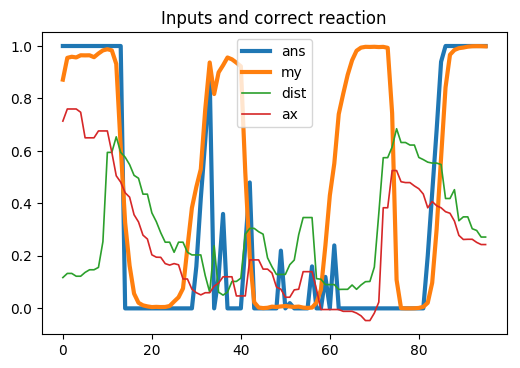

In [17]:
tx, ty = dataset.next_batch(56, tp="test")
yp = sess.run(y_, feed_dict={x:tx, keep_prob:1})
tx = tx[0, :]
ty = ty[0, :]
plt.figure(dpi=100)
plt.plot(ty, linewidth=3)
plt.plot(yp[0, :], linewidth=3)
plt.plot(tx[:, 0], linewidth=1.2)
plt.plot(tx[:, 1], linewidth=1.2)
plt.legend(["ans", "my", "dist", "ax", "gx", "gy", "gz", "shake"])
plt.title("Inputs and correct reaction")
plt.show()

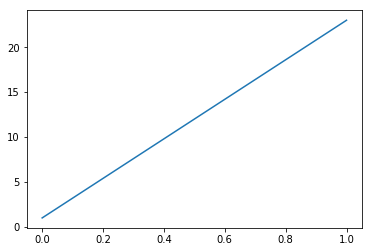

In [7]:
plt.figure()
plt.plot([1,23])
plt.show()

In [23]:
_s = tf.nn.rnn_cell.LSTMStateTuple(tf.placeholder("float",[1, 32]), tf.placeholder("float", [1, 32]))
_o = tf.placeholder("float", [1, 32])
_x = tf.placeholder("float", [1, 8])
_a = tf.nn.softsign(tf.matmul(_x, Wh) + bh)
_cell = lstm_cell(_a, _s)
_y = tf.sigmoid(tf.matmul(_o, Wo) + bo)
all_x = dataset.all_data
hist = []

feed_state = (np.zeros((1, 32)), np.zeros((1, 32)))
for i in range(180):
    feed_out, feed_state = sess.run(_cell, feed_dict={
        _x: all_x.x[i:i+1, :],
        _s: feed_state
    })
    ans = sess.run(_y, feed_dict={
        _o: feed_out
    })
    hist.append(ans[0,0])

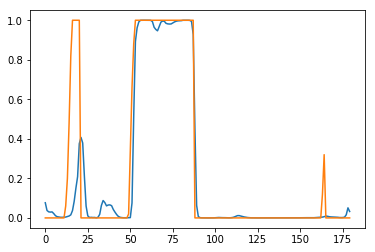

In [24]:
start = 0
to = 180
plt.figure()
plt.plot(hist[start:to])
# print(np.sum(hist))
plt.plot(all_x.y.reshape([-1])[start:to])
plt.show()

In [34]:
import RPi.GPIO as GPIO
import time
import atexit
import Adafruit_PCA9685
from threading import Thread